In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 6,078
training + validation N: 24,405


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,193,15,-0.074999,UUCGCGCCA
2,training,27,0,-0.438475,UAAGCUUUU
3,training,130,2,-0.631467,AUGGUCGGG
4,training,552,19,-0.433012,AGGGCAGGA


In [3]:
# load weights and set these weights to current additive gpmap to 
# check whether x_to_phi is working correctly
mpsa_theta = pd.read_csv('data/mpsa_ge_additive_theta.csv',index_col=[0])
mpsa_theta

,A,C,G,U
0,0.189997,0.245957,-0.215436,-0.222793
1,0.486258,-0.031005,-0.207988,-0.246489
2,-0.325754,-0.315853,1.070888,-0.437522
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,-0.911139,0.000000,0.941255
5,0.943106,-0.495813,0.132037,-0.535949
6,0.499349,-0.032492,-0.294187,-0.189754
7,-0.230271,-0.330037,0.748948,-0.261761
8,-0.159224,-0.083537,-0.097654,0.319998


In [4]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A','C','G','U']

In [5]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# set parameters to mpsa model 
# this is done to check for validity of updated x_to_phi
gpmap.set_params(theta_0=-2.508132402430794,
                 theta_lc=mpsa_theta.values)

# get test set data.
x_test = test_df['x'].values
y_test = test_df['y'].values

2022-02-11 14:06:29.192364: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Updated phi usage
Computed directly from gpmap object

In [6]:
phi = gpmap.x_to_phi(x_test)


### Validate gpmap object usage

Text(0.5, 0, 'phi')

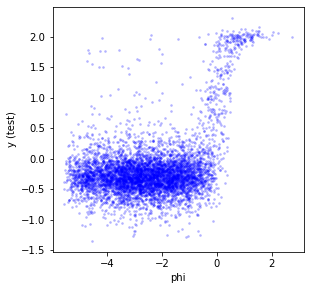

In [7]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.scatter(phi,y_test,s=3,alpha=0.2,c='b')
ax.set_ylabel('y (test)')
ax.set_xlabel('phi')

### Create measurement process object(s)

In [8]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_GE_1 = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=20)

mp_GE_2 = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=50)

mp_MPA = mavenn.measurement_process_layers.DiscreteAgnosticMP(Y=2,
                                                              K=20,
                                                              info_for_layers_dict={'H_y_norm':0},
                                                              eta=1e-5)


about to call super from discrete Agnostic


In [9]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_GE_1,mp_GE_2, mp_MPA])

In [10]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 37)]        0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 36)           0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           37          ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

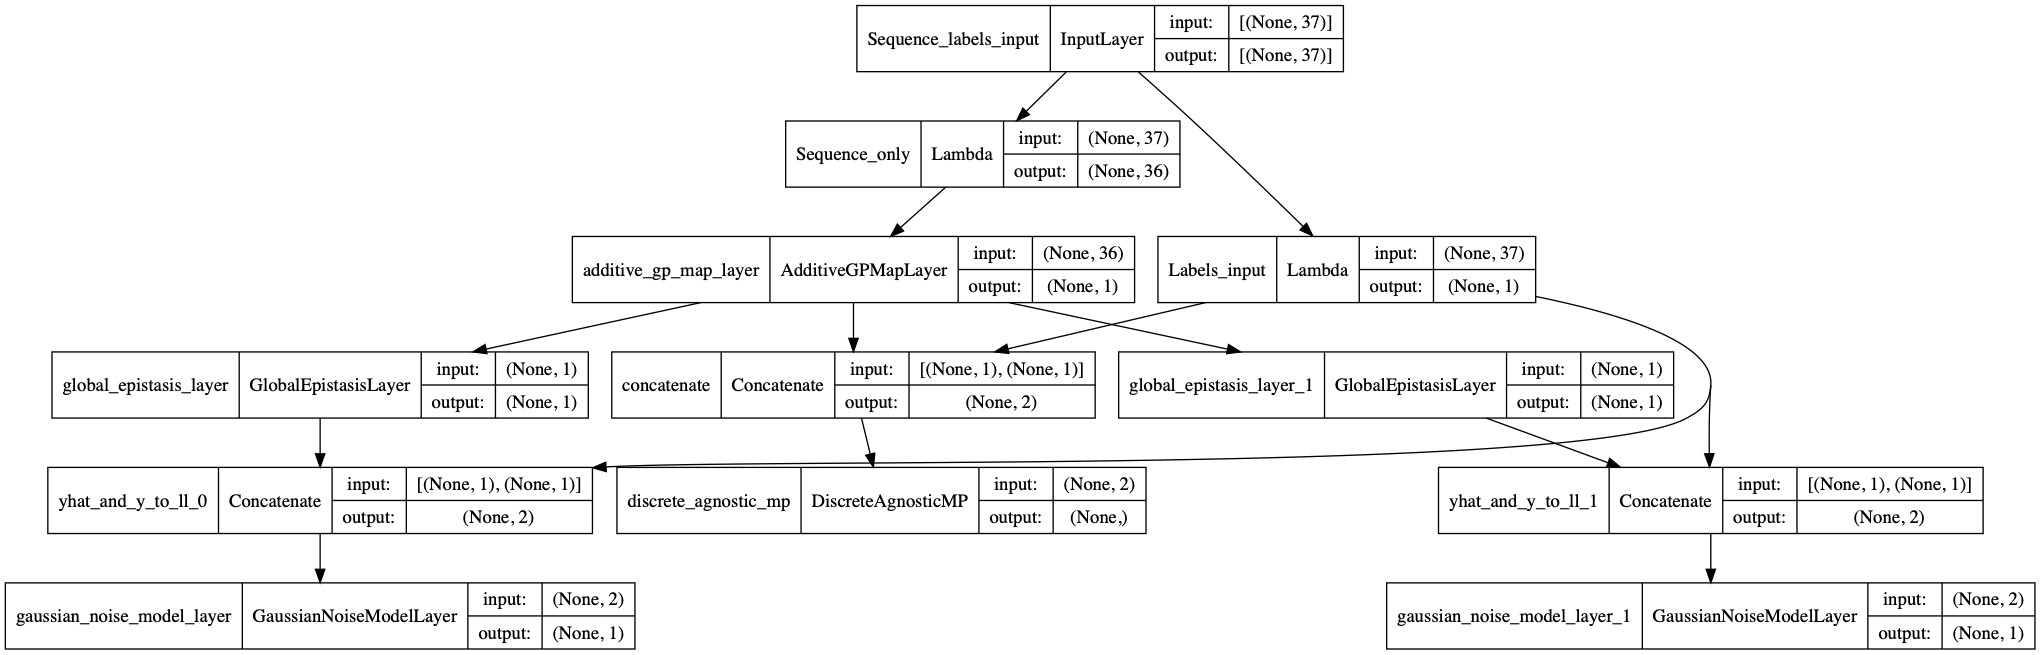

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True)

In [12]:
mp_GE_1.phi_to_yhat(phi)

<tf.Tensor: shape=(6078, 1), dtype=float32, numpy=
array([[-1.2890363 ],
       [ 0.40374097],
       [-1.1252515 ],
       ...,
       [-1.3132985 ],
       [-1.3142929 ],
       [ 0.5808168 ]], dtype=float32)>

In [13]:
mp_GE_2.p_of_y_given_phi(phi,y_test)

<tf.Tensor: shape=(6078, 6078), dtype=float32, numpy=
array([[0.36781242, 0.06333509, 0.31623274, ..., 0.29799902, 0.33942977,
        0.08305192],
       [0.27139294, 0.28142467, 0.3388298 , ..., 0.35274607, 0.31552896,
        0.31277052],
       [0.37699494, 0.07723209, 0.33603966, ..., 0.31973147, 0.35576662,
        0.09966717],
       ...,
       [0.3661105 , 0.06144043, 0.313091  , ..., 0.29461744, 0.33674243,
        0.08075869],
       [0.36603892, 0.06136366, 0.31296125, ..., 0.29447806, 0.33663094,
        0.08066563],
       [0.24475883, 0.30624473, 0.3177371 , ..., 0.33425286, 0.291523  ,
        0.3345162 ]], dtype=float32)>